In [1]:
# retinaface insightface执行人脸识别

In [ ]:
import os,sys    ##ccrujing
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))   # face
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))),'retinaface'))
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))),'insightface'))

In [2]:
sys.path

['C:\\PythonProject\\find_people',
 'c:\\python38\\python38.zip',
 'c:\\python38\\DLLs',
 'c:\\python38\\lib',
 'c:\\python38',
 '',
 'c:\\python38\\lib\\site-packages',
 'c:\\python38\\lib\\site-packages\\win32',
 'c:\\python38\\lib\\site-packages\\win32\\lib',
 'c:\\python38\\lib\\site-packages\\Pythonwin',
 'c:\\python38\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Administrator\\.ipython',
 'C:\\PythonProject',
 'C:\\PythonProject\\retinaface',
 'C:\\PythonProject\\insightface']

In [ ]:
# face detect
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import cv2
import time

from retinaface.data import cfg_mnet,cfg_re50
from retinaface.layers.functions.prior_box import PriorBox
from retinaface.utils.nms.py_cpu_nms import py_cpu_nms
from retinaface.utils.box_utils import decode, decode_landm
from retinaface.models.retinaface import RetinaFace

In [5]:
# face embedding

from PIL import Image
from pathlib import Path
from multiprocessing import Process, Pipe,Value,Array
import torch
from config import get_config
from Learner import face_learner
from insight_utils import load_facebank, draw_box_name, prepare_facebank

In [6]:
# detect 超参数/home/create/jing/jing_vision/face/retinaface/weights/mobilenet0.25_Final.pth/home/create/jing/jing_vision/face/retinaface/weights/Resnet50_Final.pth
trained_model='/home/create/jing/jing_vision/face/retinaface/weights/mobilenet0.25_Final.pth'
network=  'mobile0.25'          #'resnet50'
cpu=False
confidence_threshold=0.02
top_k=5000
nms_threshold=0.4
keep_top_k=750
save_image=False
vis_thres=0.6

# embedding 超参数
prepare_image_path = '/Data/jing/face/facebank'  # facebank路径

file_name ='video.mp4'   #", help="video file name",default='video.mp4', type=str)
save_name  ='video_out.avi'  #", help="output file name",default='recording', type=str)
threshold=1.54       #',help='threshold to decide identical faces',default=1.54, type=float)
update=True           #", help="whether perform update the facebank",action="store_true")
tta =False           #", help="whether test time augmentation",action="store_true")
score=False         #", help="whether show the confidence score",action="store_true")
begin=0                #", help="from when to start detection(in seconds)", default=0, type=int)
duration=0            #", help="perform detection for how long(in seconds)", default=0, type=int)



In [7]:
# 配置embedding 模型
conf = get_config(False)
conf.use_mobilfacenet = True   # 是否使用mobilenet模型  
learner = face_learner(conf, True)
learner.threshold = threshold
if conf.device.type == 'cpu':
    print('load cpu model ...')
    learner.load_state(conf, 'cpu_final.pth', True, True)
else:
    print('load gpu model ...')
    learner.load_state(conf, 'final_mobile.pth', True, True)  # 加载指定路径下 Resnet：model_final_resnet50.pth
learner.model.eval()
print('learner loaded')

{'data_path': PosixPath('insight_data'), 'work_path': PosixPath('work_space'), 'model_path': PosixPath('work_space/models'), 'log_path': PosixPath('work_space/log'), 'save_path': PosixPath('/home/create/jing/jing_vision/face/insightface/work_space/save'), 'input_size': [112, 112], 'embedding_size': 512, 'use_mobilfacenet': True, 'net_depth': 50, 'drop_ratio': 0.6, 'net_mode': 'ir_se', 'device': device(type='cuda', index=0), 'test_transform': Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
), 'data_mode': 'emore', 'vgg_folder': PosixPath('insight_data/faces_vgg_112x112'), 'ms1m_folder': PosixPath('insight_data/faces_ms1m_112x112'), 'emore_folder': PosixPath('/Data/jing/face/faces_emore'), 'batch_size': 100, 'facebank_path': PosixPath('insight_data/facebank'), 'threshold': 1.5, 'face_limit': 10, 'min_face_size': 30}
MobileFaceNet model generated
load gpu model ...
learner loaded


In [8]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [9]:
# reference facial points, a list of coordinates (x,y)
from skimage import transform as trans
REFERENCE_FACIAL_POINTS = [
    [30.29459953, 51.69630051],
    [65.53179932, 51.50139999],
    [48.02519989, 71.73660278],
    [33.54930115, 92.3655014],
    [62.72990036, 92.20410156]
]

DEFAULT_CROP_SIZE = (96, 112)
def get_reference_facial_points(output_size=None,
                                inner_padding_factor=0.0,
                                outer_padding=(0, 0),
                                default_square=False):
    tmp_5pts = np.array(REFERENCE_FACIAL_POINTS)
    tmp_crop_size = np.array(DEFAULT_CROP_SIZE)

    # 0) make the inner region a square
    if default_square:
        size_diff = max(tmp_crop_size) - tmp_crop_size
        tmp_5pts += size_diff / 2
        tmp_crop_size += size_diff

    # print('---> default:')
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    if (output_size and
            output_size[0] == tmp_crop_size[0] and
            output_size[1] == tmp_crop_size[1]):
        # print('output_size == DEFAULT_CROP_SIZE {}: return default reference points'.format(tmp_crop_size))
        return tmp_5pts

    if (inner_padding_factor == 0 and
            outer_padding == (0, 0)):
        if output_size is None:
            print('No paddings to do: return default reference points')
            return tmp_5pts
        else:
            raise FaceWarpException(
                'No paddings to do, output_size must be None or {}'.format(tmp_crop_size))

    # check output size
    if not (0 <= inner_padding_factor <= 1.0):
        raise FaceWarpException('Not (0 <= inner_padding_factor <= 1.0)')

    if ((inner_padding_factor > 0 or outer_padding[0] > 0 or outer_padding[1] > 0)
            and output_size is None):
        output_size = tmp_crop_size * \
                      (1 + inner_padding_factor * 2).astype(np.int32)
        output_size += np.array(outer_padding)
        print('              deduced from paddings, output_size = ', output_size)

    if not (outer_padding[0] < output_size[0]
            and outer_padding[1] < output_size[1]):
        raise FaceWarpException('Not (outer_padding[0] < output_size[0]'
                                'and outer_padding[1] < output_size[1])')

    # 1) pad the inner region according inner_padding_factor
    # print('---> STEP1: pad the inner region according inner_padding_factor')
    if inner_padding_factor > 0:
        size_diff = tmp_crop_size * inner_padding_factor * 2
        tmp_5pts += size_diff / 2
        tmp_crop_size += np.round(size_diff).astype(np.int32)

    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    # 2) resize the padded inner region
    # print('---> STEP2: resize the padded inner region')
    size_bf_outer_pad = np.array(output_size) - np.array(outer_padding) * 2
    # print('              crop_size = ', tmp_crop_size)
    # print('              size_bf_outer_pad = ', size_bf_outer_pad)

    if size_bf_outer_pad[0] * tmp_crop_size[1] != size_bf_outer_pad[1] * tmp_crop_size[0]:
        raise FaceWarpException('Must have (output_size - outer_padding)'
                                '= some_scale * (crop_size * (1.0 + inner_padding_factor)')

    scale_factor = size_bf_outer_pad[0].astype(np.float32) / tmp_crop_size[0]
    # print('              resize scale_factor = ', scale_factor)
    tmp_5pts = tmp_5pts * scale_factor
    #    size_diff = tmp_crop_size * (scale_factor - min(scale_factor))
    #    tmp_5pts = tmp_5pts + size_diff / 2
    tmp_crop_size = size_bf_outer_pad
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    # 3) add outer_padding to make output_size
    reference_5point = tmp_5pts + np.array(outer_padding)
    tmp_crop_size = output_size
    # print('---> STEP3: add outer_padding to make output_size')
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)
    #
    # print('===> end get_reference_facial_points\n')

    return reference_5point

def get_affine_transform_matrix(src_pts, dst_pts):
    tfm = np.float32([[1, 0, 0], [0, 1, 0]])
    n_pts = src_pts.shape[0]
    ones = np.ones((n_pts, 1), src_pts.dtype)
    src_pts_ = np.hstack([src_pts, ones])
    dst_pts_ = np.hstack([dst_pts, ones])

    A, res, rank, s = np.linalg.lstsq(src_pts_, dst_pts_)

    if rank == 3:
        tfm = np.float32([
            [A[0, 0], A[1, 0], A[2, 0]],
            [A[0, 1], A[1, 1], A[2, 1]]
        ])
    elif rank == 2:
        tfm = np.float32([
            [A[0, 0], A[1, 0], 0],
            [A[0, 1], A[1, 1], 0]
        ])

    return tfm


def warp_and_crop_face(src_img,  # BGR
                       facial_pts,
                       reference_pts=None,
                       crop_size=(96, 112),
                       align_type='smilarity'):
    if reference_pts is None:
        if crop_size[0] == 96 and crop_size[1] == 112:
            reference_pts = REFERENCE_FACIAL_POINTS
        else:
            default_square = False
            inner_padding_factor = 0
            outer_padding = (0, 0)
            output_size = crop_size

            reference_pts = get_reference_facial_points(output_size,
                                                        inner_padding_factor,
                                                        outer_padding,
                                                        default_square)

    ref_pts = np.float32(reference_pts)
    ref_pts_shp = ref_pts.shape  # (5,2)
    if max(ref_pts_shp) < 3 or min(ref_pts_shp) != 2:
        raise FaceWarpException(
            'reference_pts.shape must be (K,2) or (2,K) and K>2')

    if ref_pts_shp[0] == 2:
        ref_pts = ref_pts.T

    src_pts = np.float32(facial_pts)
    src_pts_shp = src_pts.shape   # (5,2)
    if max(src_pts_shp) < 3 or min(src_pts_shp) != 2:
        raise FaceWarpException(
            'facial_pts.shape must be (K,2) or (2,K) and K>2')

    if src_pts_shp[0] == 2:
        src_pts = src_pts.T

    if src_pts.shape != ref_pts.shape:
        raise FaceWarpException(
            'facial_pts and reference_pts must have the same shape')

    if align_type is 'cv2_affine':
        tfm = cv2.getAffineTransform(src_pts[0:3], ref_pts[0:3])
    #        print('cv2.getAffineTransform() returns tfm=\n' + str(tfm))
    elif align_type is 'affine':
        tfm = get_affine_transform_matrix(src_pts, ref_pts)
    #        print('get_affine_transform_matrix() returns tfm=\n' + str(tfm))
    else:
        # tfm = get_similarity_transform_for_cv2(src_pts, ref_pts)
        tform = trans.SimilarityTransform()
        tform.estimate(src_pts, ref_pts)
        tfm = tform.params[0:2, :]

    face_img = cv2.warpAffine(src_img, tfm, (crop_size[0], crop_size[1]))

    return face_img  # BGR

In [10]:
# 模型和device
# net and model
torch.set_grad_enabled(False)
cfg = None
if network == "mobile0.25":
    cfg = cfg_mnet
elif network == "resnet50":
    cfg = cfg_re50
retina_net = RetinaFace(cfg=cfg, phase='test')
retina_net = load_model(retina_net, trained_model, cpu)
retina_net.eval()
#     print('Finished loading model!')
#     print(net)
cudnn.benchmark = True
device = torch.device("cpu" if cpu else "cuda:0")
retina_net = retina_net.to(device)

# Model parameters
image_w = 112
image_h = 112
channel = 3
emb_size = 512
# 执行人脸对齐
def align_face(img, facial5points):
    facial5points = np.reshape(facial5points, (2, 5))
    crop_size = (image_h, image_w)
    default_square = True
    inner_padding_factor = 0.25
    outer_padding = (0, 0)
    output_size = (image_h, image_w)
#     print('output_size',output_size)
    # get the reference 5 landmarks position in the crop settings
    reference_5pts = get_reference_facial_points(output_size, inner_padding_factor, outer_padding, default_square)
#     print('reference_5pts',reference_5pts)
    # dst_img = warp_and_crop_face(raw, facial5points)
    dst_img = warp_and_crop_face(img, facial5points, reference_pts=reference_5pts, crop_size=crop_size)
#     print('dst_img',dst_img.shape)
    return dst_img



def detect_face(img=None,input_image_path = "./curve/test.jpg",output_image_path = 'test.jpg',net=retina_net,device=device):
    """
    img 输入GBR格式图片矩阵
    input_image_path 输入图片路径
    output_image_path 保存图片路径
    """
    resize = 1
    if isinstance(input_image_path,str) and img is None:
        img_raw = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
        img = np.float32(img_raw)
    else:
        img_raw = img
    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)

    tic = time.time()
    loc, conf, landms = net(img)  # forward pass
    print('net forward time: {:.4f}'.format(time.time() - tic))

    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data
    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()
    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                           img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                           img.shape[3], img.shape[2]])
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()

    # ignore low scores
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMS
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, nms_threshold)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    dets = dets[:keep_top_k, :]
    landms = landms[:keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)
    
    # show image
    for b in dets:  # b 0~3 为xmin ymin xmax ymax 4 为threshold  后面连续五个点为地标
        if b[4] < vis_thres:
            continue
        # 仅处理一张图片只有一个人脸的情况
        try:
            crop_image =img_raw[int(b[1]):int(b[3]),int(b[0]):int(b[2]),:]
            
#             resize_crop_image = cv2.resize(crop_image,(112,112))
            # 执行人脸对齐 point 按照 x1 x2 x3 x4 x5 y1 y2 y3 y4 y5
            point  =[int(i) for i in [b[5]-b[0],b[7]-b[0],b[9]-b[0], b[11]-b[0],b[13]-b[0],b[6]-b[1],b[8]-b[1],b[10]-b[1],b[12]-b[1],b[14]-b[1]]]
#             point  =[int(i) for i in [b[5]-b[0], b[6]-b[1],b[7]-b[0], b[8]-b[1], b[9]-b[0],b[10]-b[1], b[11]-b[0], b[12]-b[1], b[13]-b[0],b[14]-b[1]]]
#             return crop_image ,point
            facial5points = np.array(point)
#             print(crop_image.shape,facial5points)
            resize_crop_image = align_face(crop_image, facial5points)
            return resize_crop_image
        except:
            print('exception')
            return None
        text = "{:.4f}".format(b[4])
        b = list(map(int, b))
        cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
        cx = b[0]
        cy = b[1] + 12
        cv2.putText(img_raw, text, (cx, cy),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

        # landms
        cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
        cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)
        cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
        cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
        cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)

    # save image
    if save_image:
        cv2.imwrite(output_image_path, img_raw)
        

def prepare_my_facebank(conf, model,tta = True):
    model.eval()
    embeddings =  []
    names = ['Unknown']  # 留一个位置给unkn
    for folder_name in os.listdir(prepare_image_path):
        folder_path = os.path.join(prepare_image_path,folder_name)
        if os.path.isfile(folder_path):  # 若是文件则跳过  应该按名称命名的文件夹
            continue
        else:
            embs = []
            for image_name in os.listdir(folder_path):
                image_full_path = os.path.join(folder_path,image_name)
                if not os.path.isfile(image_full_path):
                    continue
                else:
                    face_image = detect_face(input_image_path=image_full_path)  # 返回的是GBR 格式图像 
                    if face_image is None:
                        continue
                    img = face_image[:,:,[2,1,0]]
#                     img=np.transpose(face_image,(2,0,1))
                    with torch.no_grad():
                        if tta:
                            mirror = trans.functional.hflip(img)
                            emb = model(conf.test_transform(img).to(conf.device).unsqueeze(0))
                            emb_mirror = model(conf.test_transform(mirror).to(conf.device).unsqueeze(0))
                            embs.append(l2_norm(emb + emb_mirror))
                        else:                        
                            embs.append(model(conf.test_transform(img).to(conf.device).unsqueeze(0)))
        if len(embs) == 0:
            continue
        embedding = torch.cat(embs).mean(0,keepdim=True)
        embeddings.append(embedding)
        names.append(folder_name)
    embeddings = torch.cat(embeddings)
    names = np.array(names)
    torch.save(embeddings, os.path.join(prepare_image_path,'facebank.pth'))
    np.save(os.path.join(prepare_image_path,'name.npy'), names)

    return embeddings, names

def load_my_facebank(conf):
    embeddings = torch.load(os.path.join(prepare_image_path,'facebank.pth'))
    names = np.load(os.path.join(prepare_image_path,'name.npy'))
    return embeddings, names

Loading pretrained model from /home/create/jing/jing_vision/face/retinaface/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


In [11]:
# 更新人脸字典  或加载已存在字典
update=False
if update:
    targets, names = prepare_my_facebank(conf, learner.model,tta = False)
    print('facebank updated')
else:
    targets, names = load_my_facebank(conf)
    print('facebank loaded')

facebank loaded


In [13]:
# 在图片上测试
test_image_path='/home/create/jing/jing_vision/face/image/aqgy/val/lzq/ia_1700002438.jpg'
save_image_path = '/Data/jing/face/facebank/tyy/ia_1900002420_test.jpg'
img_raw = cv2.imread(test_image_path)
test_face_image = detect_face(input_image_path=test_image_path)  # 返回的是GBR 格式图像 

net forward time: 0.1281


In [21]:
mapping_dict={
    'tyy':'唐悠悠',
    'lzq':'吕子乔',
    'cmj':'陈美嘉',
    'zxx':'曾小贤',
    'hyf':'胡一菲',
    'lwy':'林宛瑜',
    'lzb':'陆展博',
    'ggsq':'关谷神奇',
    'zw':'张伟',
    'qym':'秦羽墨',
}

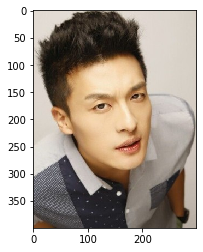

net forward time: 0.0110


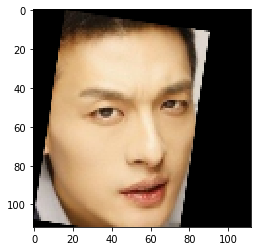

[1.0924789, 0.67145663, 0.98820984, 1.1520907, 1.1999795, 1.203456, 1.102353, 1.0413468, 1.1116664, 1.0956364, 1.1160905, 1.0185359, 1.2650806, 1.1403782, 1.2164997]
吕子乔


In [22]:
import matplotlib.pyplot as plt

# 在图片上测试
test_image_path='/home/create/jing/jing_vision/face/image/aqgy/val/lzq/ia_1700002438.jpg'
save_image_path = '/Data/jing/face/facebank/tyy/ia_1900002420_test.jpg'
img_raw = cv2.imread(test_image_path)
plt.imshow(img_raw[:,:,[2,1,0]])
plt.show()
test_face_image = detect_face(input_image_path=test_image_path)  # 返回的是GBR 格式图像 
test_img = test_face_image[:,:,[2,1,0]]
plt.imshow(test_img)
encode = learner.model(conf.test_transform(test_img).to(conf.device).unsqueeze(0))
b = encode.squeeze().cpu().numpy()
distance_list=[0]*15
for i in range(targets.shape[0]):
    a = targets[i,:].cpu().numpy()
    distance_list[i]=np.sqrt(np.sum(np.square(a-b)))

    
plt.show()
#     distance_list[i] = 1 - np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
print(distance_list)
print(mapping_dict[names[np.argmin(distance_list)+1]])  #+1的原因是第一个留给unknown

In [15]:
# 在测试集上测试准确率
test_path = '/home/create/jing/jing_vision/face/image/5-celebrity-faces-dataset/data/val'
all_count = 0
currect_count = 0
for name in os.listdir(test_path):
    print('-------------',name)
    name_folder = os.path.join(test_path,name)
    for image_name in os.listdir(name_folder):
        full_image_path = os.path.join(name_folder,image_name)
        test_face_image = detect_face(input_image_path=full_image_path)  # 返回的是GBR 格式图像 
        test_img = test_face_image[:,:,[2,1,0]]
        encode = learner.model(conf.test_transform(test_img).to(conf.device).unsqueeze(0))
        b = encode.squeeze().cpu().numpy()
        distance_list=[0]*15
        for i in range(targets.shape[0]):
            a = targets[i,:].cpu().numpy()
            distance_list[i]=np.sqrt(np.sum(np.square(a-b)))
#             print(distance_list)
        precit_name = names[np.argmin(distance_list)+1]
        print(precit_name)  #+1的原因是第一个留给unknown
        if (name==precit_name):
            currect_count +=1
        all_count+=1
print("Accuracy:",currect_count/all_count,all_count,currect_count)

------------- jerry_seinfeld
net forward time: 0.0972
jerry_seinfeld
net forward time: 0.0907
jerry_seinfeld
net forward time: 0.0101
jerry_seinfeld
net forward time: 0.0792
jerry_seinfeld
net forward time: 0.0780
jerry_seinfeld
------------- mindy_kaling
net forward time: 0.0646
mindy_kaling
net forward time: 0.0101
mindy_kaling
net forward time: 0.0100
mindy_kaling
net forward time: 0.0790
mindy_kaling
net forward time: 0.0119
mindy_kaling
------------- ben_afflek
net forward time: 0.0904
ben_afflek
net forward time: 0.0774
ben_afflek
net forward time: 0.0109
ben_afflek
net forward time: 0.0790
ben_afflek
net forward time: 0.0100
ben_afflek
------------- madonna
net forward time: 0.0566
madonna
net forward time: 0.0101
madonna
net forward time: 0.0101
madonna
net forward time: 0.0640
madonna
net forward time: 0.0450
madonna
------------- elton_john
net forward time: 0.0101
elton_john
net forward time: 0.0100
elton_john
net forward time: 0.0100
elton_john
net forward time: 0.0100
elto

In [16]:
# 在测试集上测试准确率
test_path = '/home/create/jing/jing_vision/face/image/aqgy/val/'
all_count = 0
currect_count = 0
for name in os.listdir(test_path):
    print('-------------',name)
    name_folder = os.path.join(test_path,name)
    for image_name in os.listdir(name_folder):
        full_image_path = os.path.join(name_folder,image_name)
        test_face_image = detect_face(input_image_path=full_image_path)  # 返回的是GBR 格式图像 
        test_img = test_face_image[:,:,[2,1,0]]
        encode = learner.model(conf.test_transform(test_img).to(conf.device).unsqueeze(0))
        b = encode.squeeze().cpu().numpy()
        distance_list=[0]*15
        for i in range(targets.shape[0]):
            a = targets[i,:].cpu().numpy()
            distance_list[i]=np.sqrt(np.sum(np.square(a-b)))
#             print(distance_list)
        precit_name = names[np.argmin(distance_list)+1]
        print(precit_name)  #+1的原因是第一个留给unknown
        if (name==precit_name):
            currect_count +=1
        all_count+=1
print("Accuracy:",currect_count/all_count,all_count,currect_count)

------------- ggsq
net forward time: 0.2092
ggsq
net forward time: 0.1679
ggsq
net forward time: 0.1761
ggsq
net forward time: 0.1700
ggsq
net forward time: 0.1674
ggsq
net forward time: 0.1785
ggsq
------------- lzq
net forward time: 0.1839
lzq
net forward time: 0.1676
lzq
net forward time: 0.1900
lzq
net forward time: 0.0779
lzq
net forward time: 0.1703
lzq
net forward time: 0.0100
lzq
------------- zw
net forward time: 0.4587
zw
net forward time: 0.1632
zw
net forward time: 1.8873
lzq
net forward time: 0.1959
zw
net forward time: 0.1748
zw
------------- tyy
net forward time: 0.0233
tyy
net forward time: 0.1705
tyy
net forward time: 0.0714
tyy
net forward time: 0.0103
tyy
net forward time: 0.1574
tyy
net forward time: 0.0102
cmj
------------- hyy
net forward time: 0.1351
hyf
net forward time: 0.1815
hyf
net forward time: 0.0103
hyf
net forward time: 0.1347
hyf
net forward time: 0.2591
hyf
net forward time: 0.1634
hyf
------------- qym
net forward time: 0.1581
qym
net forward time: 0.

In [ ]:
input_video_name='/home/create/jing/jing_vision/face/aqgy.flv'
out_video_name = '/home/create/jing/jing_vision/face/aqgy_out_insight.avi'

In [ ]:
videoCapture = cv2.VideoCapture(input_video_name)
fps = int(videoCapture.get(cv2.CAP_PROP_FPS))
w = videoCapture.get(3)
h = videoCapture.get(4)
print('w,h',w,h)
print('fps:',fps)
fourcc_1 = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')  # opencv3.0
size = (int(w),int(h))
# 指定写视频的格式, I420-avi, MJPG-mp4
write_video_path = out_video_name
print('写入视频路劲：',write_video_path)
videoWriter = cv2.VideoWriter(write_video_path, fourcc_1, int(fps), size)
frame_count=0
while True:
    start_time = time.time()
    # print('当前帧:', fream_count)
    rval, frame = videoCapture.read()
    if rval is False:
        print('video is over')
        break
    if frame_count%(2)==0:    #int(fps)*7
#         im = Image.fromarray(np.uint8(frame[:,:,[2,1,0]]))
        im = np.float32(frame[:,:,[2,1,0]])
        test_face_image = detect_face(img=im,input_image_path=None)  # 返回的是GBR 格式图像 
        if test_face_image is None:
            continue
        test_img = test_face_image[:,:,[2,1,0]]
        encode = learner.model(conf.test_transform(test_img).to(conf.device).unsqueeze(0))
        b = encode.squeeze().cpu().numpy()
        distance_list=[0]*10
        for i in range(targets.shape[0]):
            a = targets[i,:].cpu().numpy()
            distance_list[i]=np.sqrt(np.sum(np.square(a-b)))
#         print(distance_list)
        name = names[np.argmin(distance_list)+1]  #+1的原因是第一个留给unknown
        
        cv2.putText(frame, name, (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 5)
        
        process_frame_time = time.time()
        print('处理帧fps:',1/(process_frame_time-start_time))
        # cv2.imshow("Frame", frame)
        # cv2.waitKey(1)
    videoWriter.write(frame)
    frame_count += 1
videoCapture.release()
videoWriter.release()